In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import os
import sys

In [2]:
from IPython.display import clear_output
from time import sleep

In [3]:
#addition module dir to path
module_dir = os.path.split( os.getcwd() )[:-1][0]
sys.path.append(module_dir)

In [4]:
from src.envs.wh_env import WarehouseEnv

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [7]:
src_dir = os.getcwd()
data_dir = '/Users/albelyakov/Data/rl_warehouse'
models_dir = os.path.join(module_dir, 'models')

#### Working with map

In [8]:
from src.envs import wh_map as wm
from src.envs import wh_objects as wo

In [9]:
import subprocess
import readline

In [10]:
def render_map(map_obj, agent_obj):
#     os.system('clear')
#     subprocess.call('reset')
    readline.clear_history()
    for i, row in enumerate(map_obj):
        to_print = list()
        for j, obj in enumerate(row):
            if (i, j) == agent_obj.coordinates:
                to_print.append(agent_obj.sprite)
            else:
                to_print.append(obj.sprite)
        print(''.join(to_print))

In [33]:
map_obj = wm.init_wh_map(wm.wh_vis_map)

In [ ]:
render_map(map_obj)

In [34]:
agent = wo.Agent(
    coordinates=(18,9)
)

In [ ]:
render_map(map_obj, agent)

In [56]:
def sim_loop():
    map_obj = wm.init_wh_map(wm.wh_vis_map)
    agent_obj = wo.Agent(
        coordinates=(18,9)
    )
    availible_actions = set(['w', 'a', 's', 'd', 'q', 't', 'g', 'i', 'r'])
    score = 0
    render_map(map_obj, agent_obj)
    while True:
        while True:
            action = input()
            if action in availible_actions:
                break
        if action == 'w':
            r = agent_obj.move(to='u',map_obj=map_obj)
            if r == 0:
                score -= 10
        elif action == 'a':
            r = agent_obj.move(to='l',map_obj=map_obj)
            if r == 0:
                score -= 10
        elif action == 's':
            r = agent_obj.move(to='d',map_obj=map_obj)
            if r == 0:
                score -= 10
        elif action == 'd':
            r = agent_obj.move(to='r',map_obj=map_obj)
            if r == 0:
                score -= 10
        elif action == 'q':
            print('Breaking simulation.')
            break
        elif action == 't':
            r = agent_obj.take_product(product_name='MacBookPro', map_obj=map_obj)
            if r == 0:
                score -= 10
        elif action == 'g':
            r = agent_obj.put_product(product_name='MacBookPro', map_obj=map_obj)
            if r == 0:
                score -= 10
            elif r == -1:
                score -= 1000
            elif r == 10:
                score += 500
        elif action == 'i':
            r = agent_obj.inspect_shelf(map_obj=map_obj)
            if r == 0:
                score -= 10
            else:
                print(r)
        elif action == 'w':
            print('Waiting...')
        score -= 10
        render_map(map_obj, agent_obj)
        print(f'Score: {score}')

In [ ]:
sim_loop()

In [244]:
env = WarehouseEnv(
    map_sketch=wm.wh_vis_map, 
    num_turns=None, 
    max_order_line=25,
    frequency=0.05,
    simplified_state=True, 
    silent=True
)

In [245]:
epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward < -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward,
        'order_list': info['order_list']
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 615
Penalties incurred: 251


In [246]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        print(f"Order list: {frame['order_list']}")
        sleep(.1)
        
print_frames(frames)

++++++++++++++++++++
+.#..#..#..#..#..#.+
+.#..#..#..#..#..#.+
+.#..#..#..#..#..#.+
+.#..#..#..#..#..#.+
+..................+
+..................+
+.#######..#######.+
+..................+
+..................+
+.#######..#######.+
+..................+
+..................+
+.##..##..##..##..#+
+.##..##..##..##..#+
+.##..##..##..##..#+
+.##..##..##..##..#+
+..................+
+..X...............+
+..................+
+$$$$$$$$$$$$$$$$$$+
Timestep: 457
State: [ 18.           3.         -16.62385405 189.32      ]
Action: 2
Reward: -10
Order list: Ноутбук ASUS ZenBook UX530UQ: 1,
Ноутбук HP EliteBook 8570p: 1,
Ноутбук DELL INSPIRON 5370: 2,
Ноутбук ASUS Eee PC 1000HD: 1,
Ноутбук Samsung 535U4C: 2,
Ноутбук DELL Vostro 3578: 1,
Ноутбук Lenovo ThinkPad 13 Ultrabook: 1,
Ноутбук HP PAVILION 15-ck000: 1,
Ноутбук Lenovo ThinkPad L390: 1,
Ноутбук ASUS VivoBook 15 X542UN: 1,
Ноутбук DELL 500: 1,
Ноутбук Lenovo IdeaPad 720 15: 1,
Ноутбук HP ProBook 430 G6: 1,
Ноутбук Apple MacBook Air 13 with Retina

KeyboardInterrupt: 

##### Training q-learning agent

In [95]:
env.observation_space.shape

(4,)

In [120]:
def encode_state(state, encoder):
    state = tuple(state)
    if state not in encoder:
        encoder[state] = len(encoder)
    return encoder[state]

In [142]:
%%time
"""Training the agent"""

import random

q_table = np.zeros([18 * 18 * 4, env.action_space.n])

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.2
n_epoch = 100000

# For plotting metrics
all_epochs = []
all_penalties = []

env = WarehouseEnv()
encoder = dict()
for i in range(1, n_epoch + 1):
    state = env.reset()
    state = encode_state(state, encoder)
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_state = encode_state(next_state, encoder)
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value
        
        if reward < -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 100000
Training finished.

CPU times: user 26min 19s, sys: 1min 34s, total: 27min 54s
Wall time: 26min 44s


In [146]:
q_table.shape

(1296, 8)

In [163]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    state = encode_state(state, encoder)
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
#         print(state, action)
        state, reward, done, info = env.step(action)
        state = encode_state(state, encoder)
        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 1000.0
Average penalties per episode: 999.0


In [164]:
epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

state = env.reset()
state = encode_state(state, encoder)
while not done:
    action = np.argmax(q_table[state])
    state, reward, done, info = env.step(action)
    state = encode_state(state, encoder)
    if reward < -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 1000
Penalties incurred: 0


In [ ]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.05)
        
print_frames(frames)

In [10]:
from src.models.q_table import QTable

In [12]:
env = WarehouseEnv(
    map_sketch=wm.wh_vis_map, 
    num_turns=None, 
    max_order_line=15,
    frequency=-1,
    simplified_state=False, 
    silent=True
)

In [350]:
screen = env.reset()

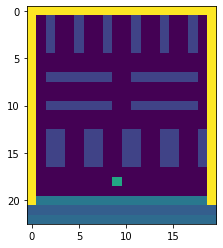

In [351]:
_ = plt.imshow(screen)

In [369]:
s, r, d, i = env.step(1)

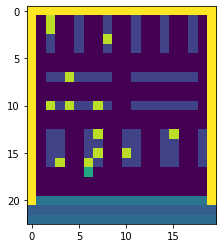

In [370]:
_ = plt.imshow(s)

In [277]:
model = QTable(
    environment=env, 
    verbose=True,
    alpha=0.40,
    gamma=0.90,
    epsilon=0.27
)

In [283]:
model.train(n_epoch=30)
# model.save_model(os.path.join(models_dir, 'qt_02_08_012_50k'))

100%|██████████| 30/30 [00:09<00:00,  3.20it/s]

Training finished.



In [284]:
# model.verbose=True
_ = model.evaluate_performance(episodes=10)

Results after 10 episodes:
Average timesteps per episode: 76.7
Average penalties per episode: 0.0
Average rewards per episode: 0.0


In [285]:
model.operate()

Timesteps taken: 71
Penalties incurred: 0
Rewards incurred: 0


In [286]:
model.show_operation()

++++++++++++++++++++
+.#..#..#..#..#..#.+
+.#..#..#..#..#..#.+
+.#..#..#..#..#..#.+
+.#..#..#..#..#..#.+
+..................+
+..................+
+.#######..#######.+
+..................+
+..................+
+.#######..#######.+
+..................+
+..................+
+.##..##..##..##..#+
+.##..##..##..##..#+
+.##..##..##..##..#+
+.##..##..##..##..#+
+..................+
+........X.........+
+..................+
+$$$$$$$$$$$$$$$$$$+
Timestep: 144
State: 0
Action: 7
Reward: -10


#### OrderList class experiments

In [11]:
from src.utils import config as co

In [12]:
from src.envs.wh_objects import OrderList

In [14]:
catalog = pd.read_csv(co.PATH_TO_CATALOG, index_col = 0)

In [15]:
catalog.head()

,name,price,purchase,weigth,long,width,depth,volume
0,Ноутбук ASUS ZenBook UX430UQ,57674.133515,0.016667,1.25,3.240,2.250,2.250,16.402500
2,Ноутбук HP ProBook 655 G3,46060.000000,1.966667,2.31,3.780,2.570,2.570,24.966522
3,Ноутбук Lenovo IdeaPad 320 17 Intel,29750.000000,0.016667,2.80,4.180,2.926,2.926,35.786970
4,Ноутбук Acer ASPIRE S5-371,57490.000000,5.500000,1.30,3.270,2.880,2.880,27.122688
5,Ноутбук Apple MacBook Pro 13 with Retina displ...,155900.000000,1.800000,1.37,3.041,2.124,2.124,13.719094


In [16]:
catalog.describe()

,price,purchase,weigth,long,width,depth,volume
count,415.000000,415.000000,415.000000,411.000000,410.000000,410.000000,409.000000
mean,57674.133515,3.385944,1.946275,3.560887,2.462067,2.462067,22.237322
std,39553.855916,4.082269,0.600479,0.375054,0.280453,0.280453,6.868680
min,100.000000,0.016667,0.850000,2.580000,1.830000,1.830000,8.640162
25%,32602.500000,0.533333,1.500000,3.240000,2.265000,2.265000,16.745054
50%,54525.000000,1.583333,1.946275,3.614000,2.465000,2.465000,22.395591
75%,68836.000000,4.975000,2.200000,3.814500,2.602250,2.602250,25.817859
max,274870.000000,16.316667,4.700000,4.323000,3.800000,3.800000,46.734976


In [17]:
catalog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 424
Data columns (total 8 columns):
name        415 non-null object
price       415 non-null float64
purchase    415 non-null float64
weigth      415 non-null float64
long        411 non-null float64
width       410 non-null float64
depth       410 non-null float64
volume      409 non-null float64
dtypes: float64(7), object(1)
memory usage: 29.2+ KB


In [19]:
print(catalog.purchase.sum())

1405.1666666666667


In [187]:
ol = OrderList(path_to_catalog=co.PATH_TO_CATALOG)

In [211]:
ol()
print(ol)

Ноутбук ASUS Vivobook 17 X705MA: 1,
Ноутбук MSI GF75 Thin 8RC: 1,
Ноутбук ASUS TUF Gaming FX705GM: 1,
Ноутбук HP 17-bs000: 1,
Ноутбук Lenovo THINKPAD T530: 1,
Ноутбук MSI GE75 8SF Raider: 1


In [212]:
np.sum([int(prod.n_purchase) for prod in ol.list_of_products])

1218

In [216]:
len(ol)

5

In [215]:
del ol['Ноутбук MSI GE75 8SF Raider']

#### Try nn

In [19]:
from keras.optimizers import Adam
from collections import Counter, deque
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop

from rl.agents.dqn import DQNAgent
from rl.core import Processor
from rl.policy import BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory


In [49]:
def build_model(input_shape, n_actions):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_actions, activation='softmax'))
    model.compile(Adam(lr=1e-3), 'mae')
    return model

In [50]:
model = build_model(input_shape=(23,20,1), n_actions=env.action_space.n)

In [58]:
class CustomProcessor(Processor):
    '''
    acts as a coupling mechanism between the agent and the environment
    '''

    def process_state_batch(self, batch):
        '''
        Given a state batch, I want to remove the second dimension, because it's
        useless and prevents me from feeding the tensor into my CNN
        '''
        return np.squeeze(batch, axis=1)

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 21, 18, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 19, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 8, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 8, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

In [60]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()
# policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=50000)
dqn = DQNAgent(model=model, nb_actions=env.action_space.n, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy, processor=pr)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [59]:
pr = CustomProcessor()

In [61]:
dqn.fit(env, nb_steps=50000, visualize=True, verbose=2)

Training for 50000 steps ...


/anaconda3/envs/reinforcement_learning/lib/python3.7/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/anaconda3/envs/reinforcement_learning/lib/python3.7/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


done, took 490.678 seconds
